In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.cross_validation import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics

/Users/Ruixuan/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df = pd.read_csv("kc_house_data.csv", date_parser=['date'])

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df1 = df.drop(['id','date'], axis = 1)
y = df1['price']
x = df1.drop(['price'],axis = 1)

In [6]:
x.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### slicing k_c housing.csv into training and test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 23)

### standardlize the data

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data. For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [8]:
scalerx = StandardScaler().fit(x_train)
scalery = StandardScaler().fit(y_train)
x_train = scalerx.transform(x_train)
y_train = scalery.transform(y_train)
x_test = scalerx.transform(x_test)
y_test = scalery.transform(y_test)

/Users/Ruixuan/Library/Python/2.7/lib/python/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Ruixuan/Library/Python/2.7/lib/python/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Ruixuan/Library/Python/2.7/lib/python/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either usin

In [9]:
def train_crossvalidation(algo, x_train, y_train):
    cv = KFold(x_train.shape[0], 5, shuffle = True, random_state = 23)
    score = cross_val_score(algo, x_train, y_train, cv = cv, scoring = 'neg_mean_squared_error')
    cv_score = np.mean(abs(score))
    R2 = cross_val_score(algo, x_train, y_train, cv = cv, scoring = 'r2')
    cv_R2 = np.mean(R2)
    print "cross validation error is", cv_score
    print "R square", round(cv_R2*100,2)

## algo1 : SGD regressor

In [10]:
SGD = linear_model.SGDRegressor(loss = 'squared_loss', penalty = None, random_state = 30)

In [11]:
train_crossvalidation(SGD, x_train, y_train)

cross validation error is 0.307634953431
R square 69.1


In [12]:
# L1 norm penlaty: the sum of the absolute value of coefficients
SGD1 = linear_model.SGDRegressor(loss = 'squared_loss', penalty = 'L1', random_state = 30)

In [13]:
train_crossvalidation(SGD1, x_train, y_train)

cross validation error is 0.307612159217
R square 69.1


In [14]:
# L2 norm penlaty: squared sum of the coefficients
SGD2 = linear_model.SGDRegressor(loss = 'squared_loss', penalty = 'L2', random_state = 30)
train_crossvalidation(SGD2, x_train, y_train)

cross validation error is 0.307633907751
R square 69.1


## algo2 : SVM

In [15]:
svm1 = SVR(kernel = 'rbf')

In [16]:
train_crossvalidation(svm1, x_train, y_train)

cross validation error is 0.246638804621
R square 76.03


## algo3:  random forests

In [17]:
from sklearn import ensemble

We use Extra Trees, aka randomized decision trees. This method adds an extra level of randomization. It not only selects for each tree a different, random subset of features, but also randomly selects the threshold for each decision, so that it improve the prediction accuracy and avoid overfitting

In [18]:
forest = ensemble.ExtraTreesRegressor(random_state = 24)

In [19]:
train_crossvalidation(forest, x_train, y_train)

cross validation error is 0.146190288007
R square 85.4


In [20]:
features = x.columns
print type(features)

<class 'pandas.indexes.base.Index'>


In [21]:
importance = zip(x.columns.values,forest.fit(x_train,y_train).feature_importances_)
print importance

[('bedrooms', 0.0084677005721172701), ('bathrooms', 0.021539391293890341), ('sqft_living', 0.18367784003491897), ('sqft_lot', 0.012574995287934149), ('floors', 0.0078514454262075851), ('waterfront', 0.041027123799182511), ('view', 0.02550501707358448), ('condition', 0.0092021935747165721), ('grade', 0.36939586558879961), ('sqft_above', 0.033007079069238485), ('sqft_basement', 0.012685626518951897), ('yr_built', 0.041484387939024432), ('yr_renovated', 0.0063213511069296858), ('zipcode', 0.016960212671585657), ('lat', 0.12261252299158146), ('long', 0.044789199933615097), ('sqft_living15', 0.030581494679286347), ('sqft_lot15', 0.012316552438435546)]


In [22]:
sorted(importance, key=lambda tup: tup[1], reverse=True)

[('grade', 0.36939586558879961),
 ('sqft_living', 0.18367784003491897),
 ('lat', 0.12261252299158146),
 ('long', 0.044789199933615097),
 ('yr_built', 0.041484387939024432),
 ('waterfront', 0.041027123799182511),
 ('sqft_above', 0.033007079069238485),
 ('sqft_living15', 0.030581494679286347),
 ('view', 0.02550501707358448),
 ('bathrooms', 0.021539391293890341),
 ('zipcode', 0.016960212671585657),
 ('sqft_basement', 0.012685626518951897),
 ('sqft_lot', 0.012574995287934149),
 ('sqft_lot15', 0.012316552438435546),
 ('condition', 0.0092021935747165721),
 ('bedrooms', 0.0084677005721172701),
 ('floors', 0.0078514454262075851),
 ('yr_renovated', 0.0063213511069296858)]

In [23]:
importances = forest.feature_importances_
indices = np.argsort(importances)

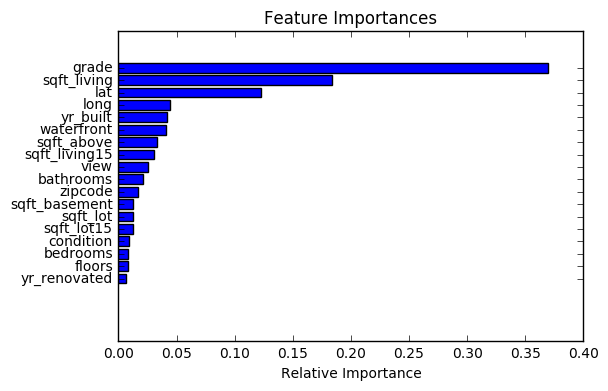

In [24]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')